#### Multi-input Denoising Autoencoder vs DAE
- Load Data
- Normalize
- Add Noise (Swap)
- Split into datasets
- Define Multi-input AE model
- Train Multi DAE on split noisy data, and DAE on concatenated noisy data
- Define classifier and clustering evaluation models
- Evaluate latent space and compare

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Data
ctg_data = pd.read_csv('../CTGRawData.csv', sep=';')
# Separate Features from labels (last column)
y = ctg_data['NSP']
X = ctg_data.drop('NSP',axis=1).iloc[:,:21]
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X))
X_swapped = X_norm

# Add swap noise to dataset
# Swap Noise 15% - 1700*0.15 = 255
swap_noise = 0.15
num_swaps = round(X_norm.shape[0]*swap_noise)
print(f"swapping: {num_swaps} rows.")

for col in range(X_norm.shape[1]):
    to_swap_rows = np.random.randint(X_norm.shape[0], size=num_swaps)
    sample_rows = np.random.randint(X_norm.shape[0], size=num_swaps)
    
    X_swapped.iloc[to_swap_rows,col] = X_norm.iloc[sample_rows,col].values

# Divide the dataset into 2 subsets with fewer features, approximately in half.
X_first = X_swapped.iloc[:,:11]
X_second = X_swapped.iloc[:,11:]

## So we get both inputs: "X_swapped" for the DAE and "X_first" and X_second for the Multi DAE.

swapping: 319 rows.


In [5]:
### MODELS DEFINITION
from typing import Tuple

# Define the multi-input multi-output model using the keras functional API
def build_multi_autoencoder(encoding_dim: int, number_features: Tuple, regularizer: tf.keras.regularizers.Regularizer, dropout: float):
    """Two-input autoencoder build function
       Parameters: encoding_dim: Size of the latent space (bottleneck layer size).
                   number_features: Tuple with the sizes of the two inputs.
                   regularizer: keras regularizer object
       Returns the 3 models: full autoencoder, the encoder part and the decoder part
    """
    if dropout > 1:
        dropout = 1
    elif dropout < 0:
        dropout = 0
    # this is the reduction of our encoded representations, in times.
    print(f"Compression: {sum(number_features)/encoding_dim}")

    first_layer_size = 16
    second_layer_size = 8
    
    ## First Dataset input path
    # encoder first input placeholder.
    first_input = layers.Input(shape=(number_features[0]))
    # encoder first path first Hidden Layer - H11
    H11 = layers.Dense(first_layer_size, activation='relu', kernel_regularizer=regularizer)(first_input)
    # encoder first path first Dropout Layer - D11
    D11 = layers.Dropout(dropout)(H11)
    # encoder first path first Batch Normalization Layer - BN11
    BN11 = layers.BatchNormalization()(D11)
    # encoder first path second Hidden Layer - H12
    H12 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN11)
    # encoder first path second Dropout Layer - D12
    D12 = layers.Dropout(dropout)(H12)
    # encoder first path second Batch Normalization Layer - BN12
    BN12 = layers.BatchNormalization()(D12)

   
    ## Second Dataset input path
    # encoder second input placeholder
    second_input = layers.Input(shape=(number_features[1]))
    # encoder second path first Hidden Layer - H21
    H21 = layers.Dense(first_layer_size, activation='relu', kernel_regularizer=regularizer)(second_input)
    # encoder second path first Dropout Layer - D21
    D21 = layers.Dropout(dropout)(H21)
    # encoder second path first Batch Normalization Layer - BN21
    BN21 = layers.BatchNormalization()(D21)
    # encoder second path second Hidden Layer - H22
    H22 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN21)
    # encoder second path second Dropout Layer - D22
    D22 = layers.Dropout(dropout)(H22)
    # encoder second path second Batch Normalization Layer - BN22
    BN22 = layers.BatchNormalization()(D22)

    
    ## Concatenate paths - Bottleneck 
    concatenated = layers.concatenate([BN12, BN22], axis=-1)
    bottleneck = layers.Dense(encoding_dim, activation='relu', kernel_regularizer=regularizer)(concatenated)

    # this model maps an input to its encoded representation
    encoder = keras.models.Model([first_input,second_input], bottleneck, name='encoder')

    ## Decoder Outputs
    # Decoder Input Layer - Encoding dimension - D1
    encoded_input = layers.Input(shape=(encoding_dim,))
    # Main joint output hidden layer - D1 
    D1 = layers.Dense(first_layer_size, activation='relu', kernel_regularizer=regularizer)(encoded_input)
    
    ## Paths Split
    ## First Dataset output path
    # decoder first path first Dropout Layer - D13
    D13 = layers.Dropout(dropout)(D1)
    # decoder first path first Batch Normalization Layer - BN13 
    BN13 = layers.BatchNormalization()(D13)
    # decoder first path first Hidden Layer - H13
    H13 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN13)
    # decoder first path second Batch Normalization Layer - BN14 
    D14 = layers.Dropout(dropout)(H13)
    # decoder first path reconstruction layer - O1
    BN14 = layers.BatchNormalization()(D14)
    # decoder first path second Dropout Layer - D14
    O1 = layers.Dense(number_features[0], activation='sigmoid')(BN14)
    
    ## Second path output hidden
    # second output hidden layer
    D23 = layers.Dropout(dropout)(D1)
    # decoder second path first Hidden Layer - H13
    BN23 = layers.BatchNormalization()(D23)
    # decoder second path first Dropout Layer - D23
    H23 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN23)
    # decoder second path second Dropout Layer - D14
    D24 = layers.Dropout(dropout)(H23)
    # decoder second path second Batch Normalization Layer - BN14 
    BN24 = layers.BatchNormalization()(D24)
    # decoder second path reconstruction layer - O1
    O2 = layers.Dense(number_features[1], activation='sigmoid')(BN24)

    # create the decoder model
    decoder = keras.models.Model(encoded_input, [O1, O2])

    # create the full autoencoder
    encoder_model = encoder([first_input, second_input])
    decoder_model = decoder(encoder_model)

    autoencoder = keras.models.Model([first_input,second_input], decoder_model, name="autoencoder")
    
    return autoencoder, encoder, decoder

# Define the model using the keras functional API
def build_autoencoder(encoding_dim: int, number_features: int, regularizer: tf.keras.regularizers.Regularizer, dropout: float):
    """Two-input autoencoder build function
       Parameters: encoding_dim: Size of the latent space (bottleneck layer size).
                   number_features: Tuple with the sizes of the two inputs.
                   regularizer: keras regularizer object
       Returns the 3 models: full autoencoder, the encoder part and the decoder part
    """
    if dropout > 1:
        dropout = 1
    elif dropout < 0:
        dropout = 0
    # this is the reduction of our encoded representations, in times.
    print(f"Compression: {number_features/encoding_dim}")

    first_layer_size = 16
    second_layer_size = 8
    
    ## ENCODER
    # encoder first input placeholder.
    first_input = layers.Input(shape=(number_features))
    # encoder first Hidden Layer - H1
    H1 = layers.Dense(first_layer_size, activation='relu', kernel_regularizer=regularizer)(first_input)
    # encoder first Dropout Layer - D1
    D1 = layers.Dropout(dropout)(H1)
    # encoder first Batch Normalization Layer - BN1
    BN1 = layers.BatchNormalization()(D1)
    # encoder second Hidden Layer - H2
    H2 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN1)
    # encoder second Dropout Layer - D2
    D2 = layers.Dropout(dropout)(H2)
    # encoder first path second Batch Normalization Layer - BN2
    BN2 = layers.BatchNormalization()(D2)

   
    ## BOTTLENECK 
    bottleneck = layers.Dense(encoding_dim, activation='relu', kernel_regularizer=regularizer)(BN2)

    # this model maps an input to its encoded representation
    encoder = keras.models.Model(first_input, bottleneck, name='encoder')

    ## DECODER
    # Decoder Input Layer - Encoding dimension
    encoded_input = layers.Input(shape=(encoding_dim,))
    # decoder first Dropout Layer - D3
    D3 = layers.Dropout(dropout)(encoded_input)
    # decoder first Batch Normalization Layer - BN3 
    BN3 = layers.BatchNormalization()(D3)
    # decoder first Hidden Layer - H3
    H3 = layers.Dense(second_layer_size, activation='relu', kernel_regularizer=regularizer)(BN3)
    # decoder second Dropout Layer - D4
    D4 = layers.Dropout(dropout)(H3)
    # decoder second Batch Normalization Layer - BN4 
    BN4 = layers.BatchNormalization()(D4)
    # decoder reconstruction layer - O1
    O1 = layers.Dense(number_features, activation='sigmoid')(BN4)

    # create the decoder model
    decoder = keras.models.Model(encoded_input, O1)

    # create the full autoencoder
    encoder_model = encoder(first_input)
    decoder_model = decoder(encoder_model)

    autoencoder = keras.models.Model(first_input, decoder_model, name="autoencoder")
    
    return autoencoder, encoder, decoder

# Set Optimizer: Adam with learning rate=0.001
optimizer = tf.keras.optimizers.Adam(0.001)
# Set Early Stop Callback
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10,  mode='auto', baseline=None, restore_best_weights=False, verbose=1)

## Call multi autoencoder build function and get the AE, the encoder and the decoder.
d_autoencoder_multi, d_encoder_multi, d_decoder_multi = build_multi_autoencoder(encoding_dim=8,
                                                                                number_features=(X_first.shape[1],X_second.shape[1]), 
                                                                                regularizer=tf.keras.regularizers.l1_l2(0.0001,0), 
                                                                                dropout=0.5)
# Compile the autoencoder using Mean Square Error loss function for both inputs.
mu = 0.45
d_autoencoder_multi.compile(optimizer=optimizer,
                        loss=["mse","mse"],
                        loss_weights=[mu, 1-mu],
                        metrics=['mse'])

## Call autoencoder build function and get the AE, the encoder and the decoder.
d_autoencoder, d_encoder, d_decoder = build_autoencoder(encoding_dim=8, number_features=X_swapped.shape[1], regularizer=tf.keras.regularizers.l1_l2(0.0001,0), dropout=0.5)
# Compile the autoencoder using Mean Square Error loss function.
d_autoencoder.compile(optimizer=optimizer,
                        loss="mse",
                        metrics=['mse'])

Compression: 2.625
Compression: 2.625


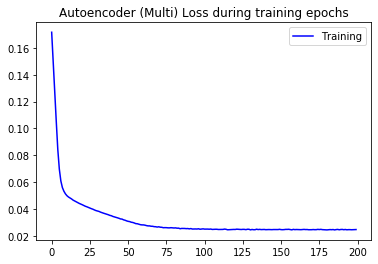

0.024606009340746048


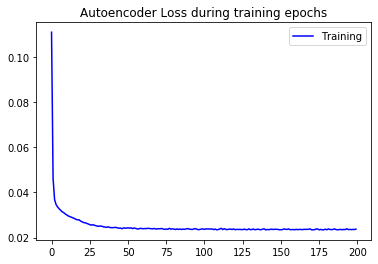

0.023754435362730628


ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[0.74074074, 0.        , 0.        , ..., 0.40366972, 0.27137546,
        1.        ],
       [0.25925926, 0.        , 0.        , ..., 0.39449541, 0.01115242,
        0.5       ],
       [0.7...

In [6]:
### TRAIN MODELS
# Fit the training data into the multi-input DAE.
history = d_autoencoder_multi.fit([X_first, X_second],[X_first, X_second],
                          epochs=200,
                          verbose=0,
                          callbacks=[])
# Plot training vs validation losses
plt.plot(history.history["loss"], c = 'b', label = "Training")
plt.title("Autoencoder (Multi) Loss during training epochs")
plt.legend()
plt.show()
print(history.history["loss"][-1])

# Fit the training data into the DAE.
d_history = d_autoencoder.fit(X_train_swapped,X_train_swapped,
                          epochs=200,
                          verbose=0,
                          callbacks=[])
# Plot training vs validation losses
plt.plot(d_history.history["loss"], c = 'b', label = "Training")
plt.title("Autoencoder Loss during training epochs")
plt.legend()
plt.show()
print(d_history.history["loss"][-1])

# Split datasets
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm,y,test_size=0.2)

# Divide the dataset into 2 subsets with fewer features, approximately in half.
X_train_first = X_train.iloc[:,:11]
X_train_second = X_train.iloc[:,11:]
X_test_first = X_train.iloc[:,:11]
X_test_second = X_train.iloc[:,11:]

# Encode datasets: use "denoising encoder" to encode original data.
X_train_encoded_multi = d_encoder.predict(X_train)
X_test_encoded_multi = d_encoder.predict(X_test)
X_train_encoded = d_encoder_multi.predict(X_train)
X_test_encoded = d_encoder_multi.predict(X_test)

# Renormalize data
scaler = MinMaxScaler()
X_train_encoded_multi = pd.DataFrame(scaler.fit_transform(X_train_encoded_multi))
X_test_encoded_multi = pd.DataFrame(scaler.fit_transform(X_test_encoded_multi))
X_train_encoded = pd.DataFrame(scaler.fit_transform(X_train_encoded))
X_test_encoded = pd.DataFrame(scaler.fit_transform(X_test_encoded))

In [ ]:
### CLASSIFICATION ###
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

## Definition of the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(penalization: int, input_shape: int):
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization), input_shape=(input_shape,)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(128,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(64,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(penalization)),
    layers.Dense(3,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model


# Fit best model with multi-modal encoded data
d_model_multi = build_best_model(0.00001, len(X_train_encoded_multi.keys()))
d_history_multi = d_model_multi.fit(X_train_encoded_multi, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
d_hist_multi = pd.DataFrame(d_history_multi.history)

test_loss, test_acc = d_model.evaluate(X_test_encoded_multi, y_test_oh)

# Fit best model with concatenated data
d_model = build_best_model(0.00001, len(X_train_encoded.keys()))
d_history = d_model.fit(X_train_encoded, y_train_oh, epochs=86,
                    validation_split = 0, verbose=0, callbacks=[])
d_hist = pd.DataFrame(d_history.history)

test_loss, test_acc = d_model.evaluate(X_test_encoded, y_test_oh)

In [ ]:
### CLUSTERING ###
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
d_ae_cluster_labels = kmeans.fit_predict(X_train_encoded)
d_ae_silhouette_avg = silhouette_score(X_train_encoded, d_ae_cluster_labels)

d_ae_multi_cluster_labels = kmeans.fit_predict(X_train_encoded_multi)
d_ae_multi_silhouette_avg = silhouette_score(X_train_encoded_multi, ae_cluster_labels)

print(d_ae_cluster_labels)
print(f"DAE silhoutte score: {d_ae_silhouette_avg}")
print(ae_cluster_labels)
print(f"Multi DAE silhoutte score: {d_ae_multi_silhouette_avg}")

In [ ]:
rom sklearn.manifold import TSNE
X_train_encoded_multi_tsne = TSNE(n_components=2).fit_transform(X_train_encoded_multi)
X_train_encoded_tsne = TSNE(n_components=2).fit_transform(X_train_encoded)

X_train_encoded_multi_tsne_labeled = np.c_[X_train_encoded_multi_tsne , y_train]
X_train_encoded_tsne_labeled = np.c_[X_train_encoded_tsne , y_train]

ax2 = plt.subplot(1,2,1)
sns.scatterplot(x = X_train_encoded_multi_tsne_labeled[:,0], 
                y = X_train_encoded_multi_tsne_labeled[:,1],
                hue=X_train_encoded_multi_tsne_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
ax2.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.figure.set_size_inches( (12,4) )
ax2.set_title("t-SNE on denoised (multi) latent space")
plt.yticks(rotation=45) 
ax2 = plt.subplot(1,2,2)
sns.scatterplot(x = X_train_encoded_tsne_labeled[:,0],
                y = X_train_encoded_tsne_labeled[:,1],
                hue=X_train_encoded_tsne_labeled[:,-1],
                palette=sns.color_palette("hls")[:2:-1])
ax2.legend(bbox_to_anchor=(-0.2, 1), loc=2, borderaxespad=0.,framealpha=1, frameon=True)
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.figure.set_size_inches( (12,4) )
ax2.set_title("t-SNE on denoised latent space")
plt.yticks(rotation=45) 

plt.show()